<a href="https://colab.research.google.com/github/talisma-cassoma/ourmoney_desktop/blob/main/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Perguntas e Objetivos**  

1. Como posso gastar melhor meu dinheiro?  
2. Com o que gasto mais e como estabelecer um budget fixo?  
3. Que gastos devo eliminar?  
4. Como criar objetivos financeiros com datas?  
5. Outras Perguntas e Objetivos Relevantes  


#### 1. **Como posso gastar melhor meu dinheiro?**  
- **Análise proposta**:  
  - **Classificação de despesas por categorias**: Identificar categorias de gastos recorrentes e calcular a proporção de cada categoria em relação à receita total.  
  - **Análise de correlação**: Avaliar se há relação entre categorias de despesas e períodos de maior ou menor receita.  
  - **Recomendação**: Usar a técnica de **"agrupamento" (clustering)** para descobrir combinações de gastos típicos (e.g., alimentação e transporte) e analisar sua sustentabilidade dentro da receita.  

In [3]:
import pandas as pd
import plotly.express as px

In [113]:
df_Transactions=pd.read_excel("/content/transactions.xlsx",sheet_name="Transactions").copy()
#delete unnecessary columns
df_Transactions = df_Transactions.drop(columns={'id','owner', 'email','synced'})
#delete space in begning and end and lowercase
df_Transactions['category'] = df_Transactions['category'].apply(lambda x: str(x).strip().lower())
df_Transactions['description'] = df_Transactions['description'].apply(lambda x: str(x).strip().lower())
df_Transactions.head()

,description,type,category,price,createdAt
0,biscoitos pro yachane,outcome,extra,10.0,17-12-2024
1,bolocha para geovana,outcome,extra,29.0,17-12-2024
2,mensalidade da escola do yachane,outcome,educaçao,500.0,17-12-2024
3,presente para geovana,outcome,extra,26.5,16-12-2024
4,bolachas e iogurte,outcome,extra,22.0,16-12-2024


In [114]:
 # Verifica se a coluna 'createdAt' está no formato de string
df_Transactions['createdAt'] = pd.to_datetime(df_Transactions['createdAt'], format='%d-%m-%Y', errors='coerce')
# Cria a nova coluna 'month' com o número do mês
df_Transactions['month'] = df_Transactions['createdAt'].dt.month
df_Transactions

,description,type,category,price,createdAt,month
0,biscoitos pro yachane,outcome,extra,10.0,2024-12-17,12
1,bolocha para geovana,outcome,extra,29.0,2024-12-17,12
2,mensalidade da escola do yachane,outcome,educaçao,500.0,2024-12-17,12
3,presente para geovana,outcome,extra,26.5,2024-12-16,12
4,bolachas e iogurte,outcome,extra,22.0,2024-12-16,12
...,...,...,...,...,...,...
1127,perside,outcome,divida,1300.0,2024-02-28,2
1128,salario geovana,income,salario,10000.0,2024-02-28,2
1129,pharmacie e leite ayla,outcome,saude,742.2,2024-02-28,2
1130,cnss,income,seguro,600.0,2024-02-06,2


In [118]:
# Receita por mês
income_by_month = df_Transactions[df_Transactions['type'] == 'income'].groupby('month')['price'].sum().reset_index(name='total_income')

# Despesas por mês e categoria
expenses_by_month = df_Transactions[df_Transactions['type'] == 'outcome'].groupby(['month', 'category'])['price'].sum().reset_index()

# Unir as informações
merged_data = expenses_by_month.merge(income_by_month, on='month', how='left')
merged_data

,month,category,price,total_income
0,2,agua e luz,231.0,10600.0
1,2,alimentaçao,92.5,10600.0
2,2,aparelhos,20.0,10600.0
3,2,creche,1800.0,10600.0
4,2,divida,1950.0,10600.0
...,...,...,...,...
188,12,presentes,140.0,600.0
189,12,roupas,1325.0,600.0
190,12,talisma,804.0,600.0
191,12,transporte,1543.0,600.0


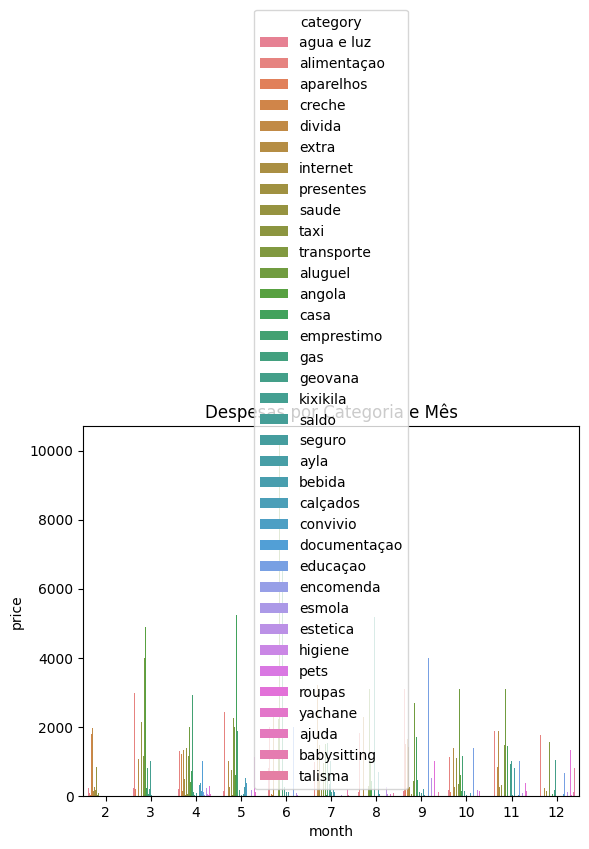

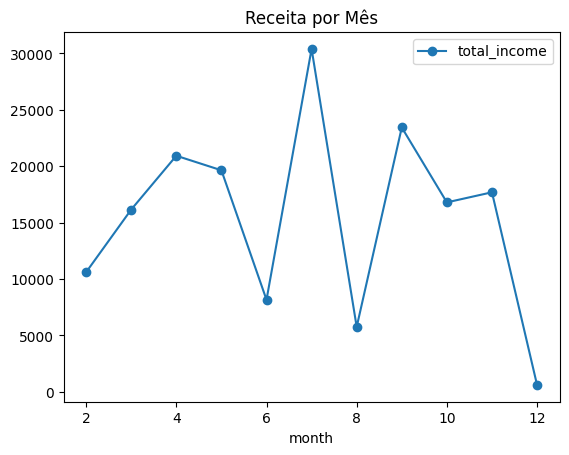

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de barras empilhadas para despesas por categoria
sns.barplot(x='month', y='price', hue='category', data=expenses_by_month)
plt.title('Despesas por Categoria e Mês')
plt.show()

# Receita por mês
income_by_month.plot(x='month', y='total_income', kind='line', marker='o', title='Receita por Mês')
plt.show()


In [123]:
# Consolidar despesas por mês
total_expenses_by_month = df_Transactions[df_Transactions['type'] == 'outcome'].groupby('month')['price'].sum().reset_index(name='total_expenses')

# Mesclar com receitas
analysis_data = income_by_month.merge(total_expenses_by_month, on='month', how='left')
analysis_data

,month,total_income,total_expenses
0,2,10600.0,5583.70
1,3,16155.0,18909.86
2,4,20925.0,16110.52
3,5,19636.0,19377.97
4,6,8150.0,26781.50
5,7,30400.0,12324.00
6,8,5745.0,15338.78
7,9,23435.0,19441.78
8,10,16790.0,11413.10
9,11,17685.0,15436.60


In [124]:
correlation = analysis_data['total_income'].corr(analysis_data['total_expenses'])
print(f"Correlação entre receita e despesas: {correlation}")

Correlação entre receita e despesas: 0.1570143434522848


In [125]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Modelo simples de regressão
X = np.array(analysis_data['total_expenses']).reshape(-1, 1)
y = np.array(analysis_data['total_income'])
model = LinearRegression().fit(X, y)

print(f"Coeficiente de relação: {model.coef_[0]}")


Coeficiente de relação: 0.22678310437535443


In [106]:
df_total= df_Transactions.groupby('type')['price'].sum().reset_index()
df_total

,type,price
0,income,170121.0
1,outcome,168671.8


In [107]:
# Filtrar apenas as despesas
df_expenses_categories = df_Transactions[df_Transactions['type'] == 'outcome']
# Filtrar apenas as receitas
df_incomes_categories = df_Transactions[df_Transactions['type'] == 'income']

# Calcular o total de despesas
total_expenses = df_expenses_categories['price'].sum()
# print results
print(f'# total of expenses: {total_expenses}')

# total of incomes
total_incomes =  df_incomes_categories['price'].sum()
print(f'total of incomes: {total_incomes}')

#total of each category
df_expenses_categories = df_expenses_categories.groupby('category')['price'].sum().reset_index()

# Adicionar a coluna de porcentagem
df_expenses_categories['perc % on expenses'] = (df_expenses_categories['price'] / total_expenses) * 100
# Adicionar a coluna de porcentagem
df_expenses_categories['perc % on income'] = (df_expenses_categories['price'] / total_incomes) * 100

# Visualizar o resultado
df_expenses_categories.head()


# total of expenses: 168671.8
total of incomes: 170121.0


,category,price,perc % on expenses,perc % on income
0,agua e luz,1974.67,1.170717,1.160744
1,ajuda,5.00,0.002964,0.002939
2,alimentaçao,19492.32,11.556360,11.457915
3,aluguel,30200.00,17.904593,17.752071
4,angola,8979.00,5.323356,5.278008


In [108]:
#total of each category
df_incomes_categories = df_incomes_categories.groupby('category')['price'].sum().reset_index()

# Adicionar a coluna de porcentagem
df_incomes_categories['perc % on income'] = (df_incomes_categories['price'] / total_incomes) * 100

# Visualizar o resultado
df_incomes_categories.head()

,category,price,perc % on income
0,bolsa amci,2500.0,1.469542
1,divida,100.0,0.058782
2,emprestimo,7690.0,4.520312
3,extra,900.0,0.529035
4,geovana,50.0,0.029391


#### 2. **Com o que gasto mais e como estabelecer um budget fixo?**  
- **Análise proposta**:  
  - Identificar as 3 principais categorias de gastos e analise a média, mediana e desvio-padrão de cada uma para entender sua variação mensal.  
  - Utilizar uma abordagem de **envelope financeiro**, dividindo sua receita proporcionalmente para atender às necessidades, desejos e poupança.  
  - Criar simulações baseadas em limites orçamentários para prever impactos financeiros.  

#### 3. **Que gastos devo eliminar?**  
- **Critérios baseados em estatísticas**:  
  - Classificar as despesas com base no índice de prioridade, considerando frequência de uso, custo-benefício e relevância (e.g., compras por impulso).  
  - Utilizar uma análise de Pareto para identificar os 20% de gastos que consomem 80% do seu orçamento.  

#### 4. **Como criar objetivos financeiros com datas?**  
- **Análise proposta**:  
  - Definir metas de poupança ou investimento usando uma abordagem incremental baseada na média histórica de sua receita líquida.  
  - Utilizar **regressão linear** para projetar tendências futuras, ajustando os objetivos com base em padrões históricos de receita e despesa.  
  - Estabeleça **KPIs pessoais**:  
    - % de despesas essenciais vs. supérfluas.  
    - % de cumprimento de metas semanais/mensais.  
    - Taxa de poupança em relação à receita.  

---

### **Outras Perguntas e Objetivos Relevantes**  

1. **Qual o impacto sazonal nas minhas receitas e despesas?**  
   - Usar análises temporais para entender como as finanças variam por mês ou estação.  

2. **Quais são minhas despesas fixas e variáveis?**  
   - Classificararas despesas entre fixas (aluguel, contas) e variáveis (lazer, alimentação fora) para entender qual delas pode ser reduzida.  

3. **Qual a minha taxa de poupança?**  
   - Compare o total economizado com sua receita total ao longo do tempo e avalie a consistência.  

4. **Onde posso alocar melhor meus excedentes financeiros?**  
   - Sugestão: Calcular a relação entre investimentos realizados e retornos financeiros.  

5. **Quais categorias apresentam maior variabilidade de mês para mês?**  
   - Calcular a variância e o coeficiente de variação para identificar as categorias menos previsíveis.  

---
### **Próximos Passos**  

- Organizar suas transações financeiras por categoria, data e tipo (fixo/variável).  
- Definir métricas claras (e.g., % de redução em categorias específicas).  
- Implementar um método de acompanhamento contínuo para ajustar o planejamento conforme necessário.  